In [2]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [543]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
                Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-40000-0.npz"#"data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [544]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [545]:
len(valid_data["Z"])

6621

In [546]:
N = 100
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]

In [547]:
# for _ in list((ddir / "vdwr14").glob("*/best*pkl")):
#     print("restart="+str(_))
#     print("sbatch --export=restart=$restart restart.sh")
#     print()

In [548]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [549]:
files = {_.parents[0].name: _ for _ in list(ddir.glob("test2/*/best*"))}
KEYS = list(files.keys())
for i, _ in enumerate(KEYS):
    print(i, _)

0 20240926-195014dcm-2-w-10000.0-re-False-ptTrue
1 20240926-195056dcm-2-w-10000.0-re-False-ptTrue
2 20240926-195338dcm-3-w-10000.0-re-False-ptTrue
3 20240926-195425dcm-3-w-10000.0-re-False-ptTrue
4 20240926-200343dcm-4-w-10000.0-re-False-ptTrue
5 20240926-201827dcm-4-w-10000.0-re-False-ptFalse
6 20240926-201855dcm-2-w-10000.0-re-False-ptFalse
7 20240926-201913dcm-3-w-10000.0-re-False-ptFalse
8 20240926-201914dcm-3-w-10000.0-re-False-ptFalse
9 20240926-201945dcm-2-w-10000.0-re-False-ptFalse
10 20240926-203255dcm-4-w-10000.0-re-False-ptTrue
11 20240926-203519dcm-4-w-10000.0-re-False-ptFalse
12 20240926-215000dcm-1-w-10000.0-re-False-ptFalse
13 20240926-215005dcm-1-w-10000.0-re-False-ptFalse


In [561]:
p = files[KEYS[6]]
print(p)
model, params = create_model_and_params(p)
model

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test2/20240926-201855dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': False, 'debug': False}


MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
    include_pseudotensors = False
)

In [ ]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)



  3%|██▊                                                                                           | 3/100 [00:02<01:12,  1.34it/s]

In [ ]:
10000 * ((1.3/627.5)**2)/2

In [ ]:
((0.0197 / 10000) * 2)**0.5 * 627.5

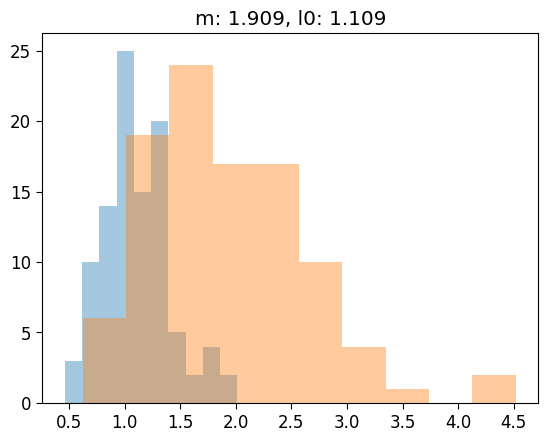

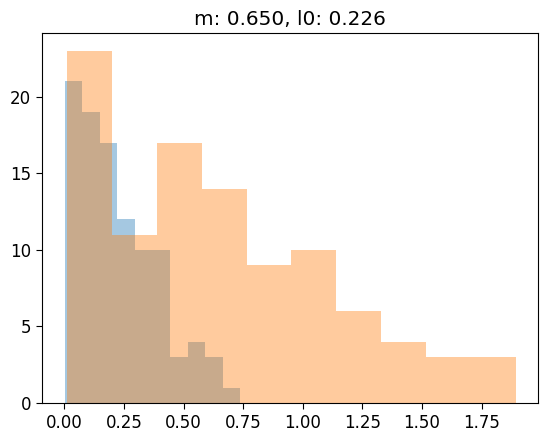

In [554]:
m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [555]:
import pandas as pd
df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten(), "dm": dm, "dl0": dl0})
df_["dif"] = df_["m"] - df_["l0"]
df_["difd"] = df_["dm"] - df_["dl0"]
df_.describe()

i           m          l0          dm         dl0  \
count   100.000000  100.000000  100.000000  100.000000  100.000000   
mean   3386.610000    1.908752    1.108507    0.649663    0.225767   
std    1922.817335    0.720047    0.301284    0.470833    0.168492   
min       8.000000    0.623242    0.462168    0.011803    0.001412   
25%    1748.750000    1.409347    0.911123    0.238008    0.089396   
50%    3354.000000    1.798316    1.069840    0.551786    0.192340   
75%    5154.500000    2.377109    1.274831    0.965684    0.353054   
max    6440.000000    4.517420    2.014815    1.893220    0.737154   

              dif        difd  
count  100.000000  100.000000  
mean     0.800245    0.423895  
std      0.626173    0.475382  
min     -0.224971   -0.382399  
25%      0.356742    0.042364  
50%      0.771328    0.356094  
75%      1.168681    0.793112  
max      3.341852    1.780156

In [556]:
good = list(df_.sort_values("m", ascending=True)["i"])
print(len(good))
df_.sort_values("m", ascending=True)[:10].describe() #.sort_values("dif", ascending=True)

100


i          m         l0         dm        dl0        dif  \
count    10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   3123.900000   0.923077   0.795389   0.187928   0.194987   0.127688   
std    2192.328009   0.174323   0.237402   0.084218   0.144017   0.251747   
min     777.000000   0.623242   0.462168   0.019002   0.052017  -0.196720   
25%    1176.750000   0.843817   0.669131   0.154421   0.099586  -0.039141   
50%    2502.000000   0.984211   0.741847   0.190061   0.145079   0.118476   
75%    5412.000000   1.055597   0.915313   0.245517   0.265566   0.250207   
max    5984.000000   1.118065   1.270344   0.316773   0.519377   0.604226   

            difd  
count  10.000000  
mean   -0.007059  
std     0.153149  
min    -0.333627  
25%    -0.059177  
50%     0.006852  
75%     0.048804  
max     0.196738

  0%|                                                                                                        | 0/5 [00:00<?, ?it/s]

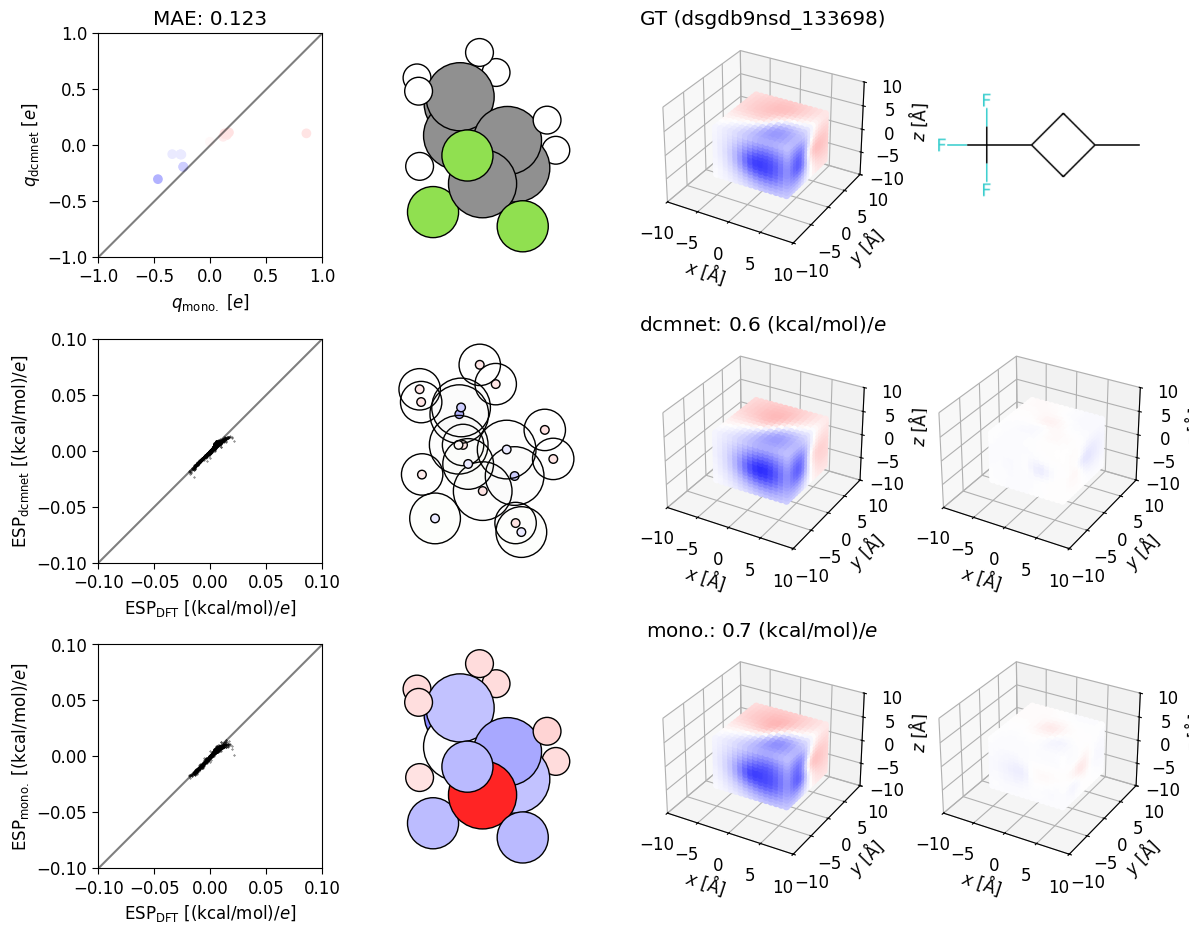

 20%|███████████████████▏                                                                            | 1/5 [00:05<00:21,  5.26s/it]

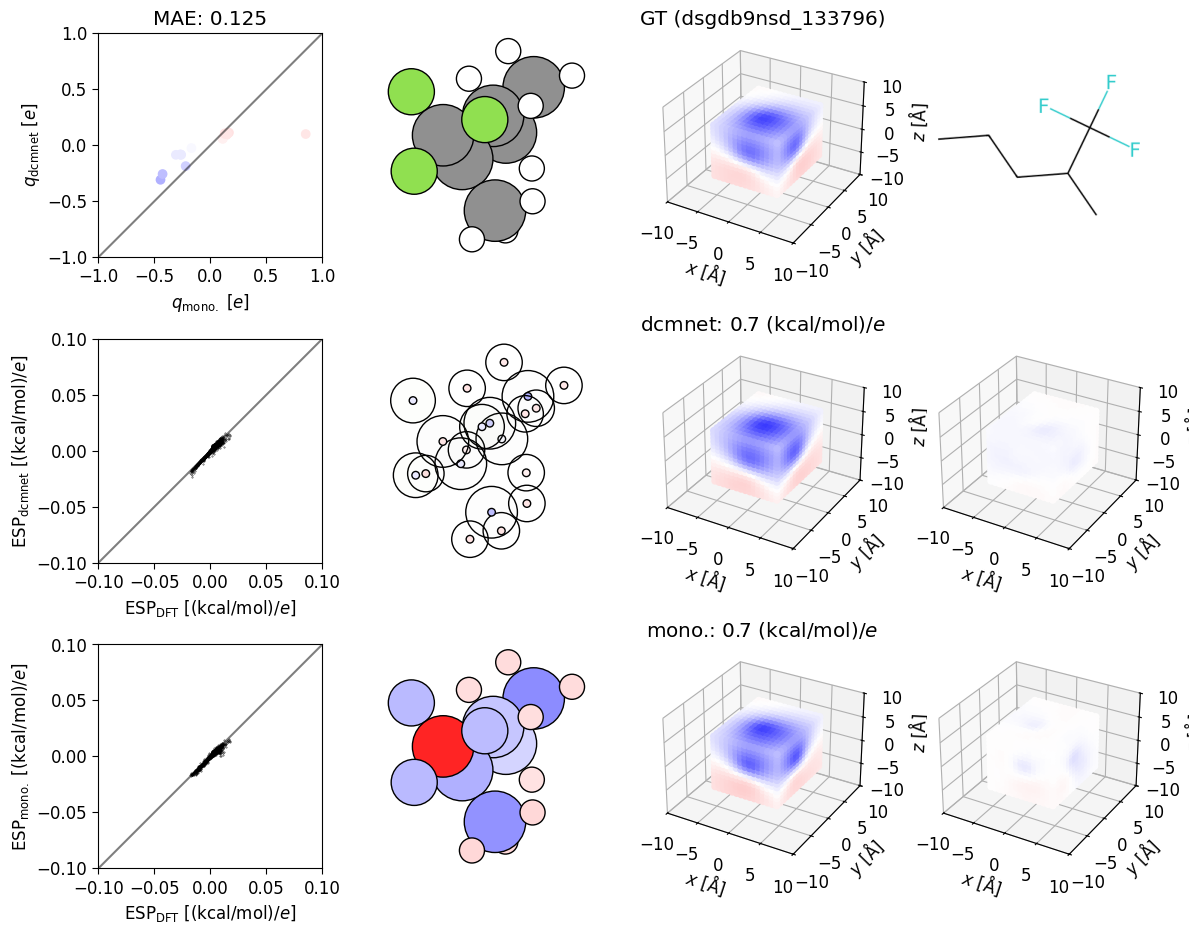

 40%|██████████████████████████████████████▍                                                         | 2/5 [00:10<00:15,  5.26s/it]

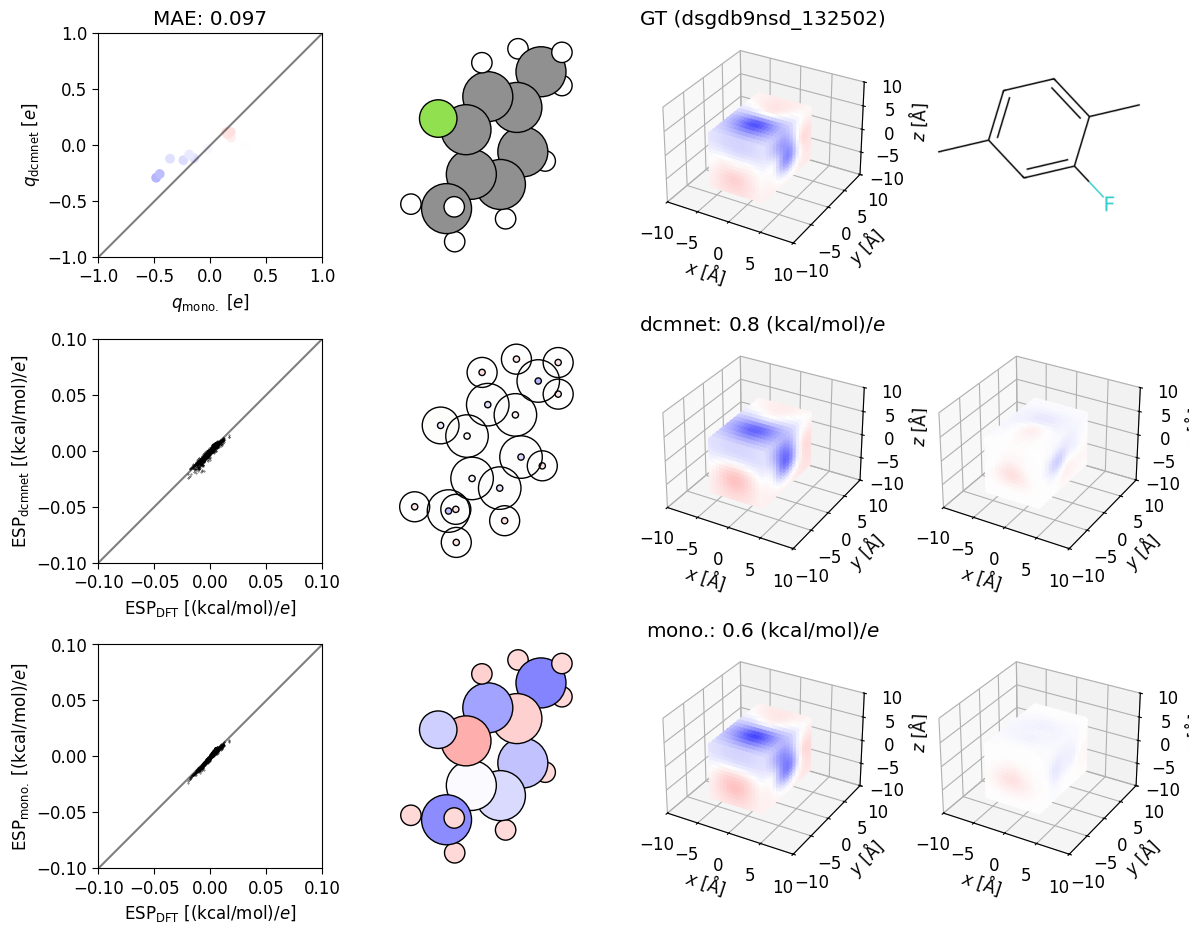

 60%|█████████████████████████████████████████████████████████▌                                      | 3/5 [00:15<00:10,  5.22s/it]

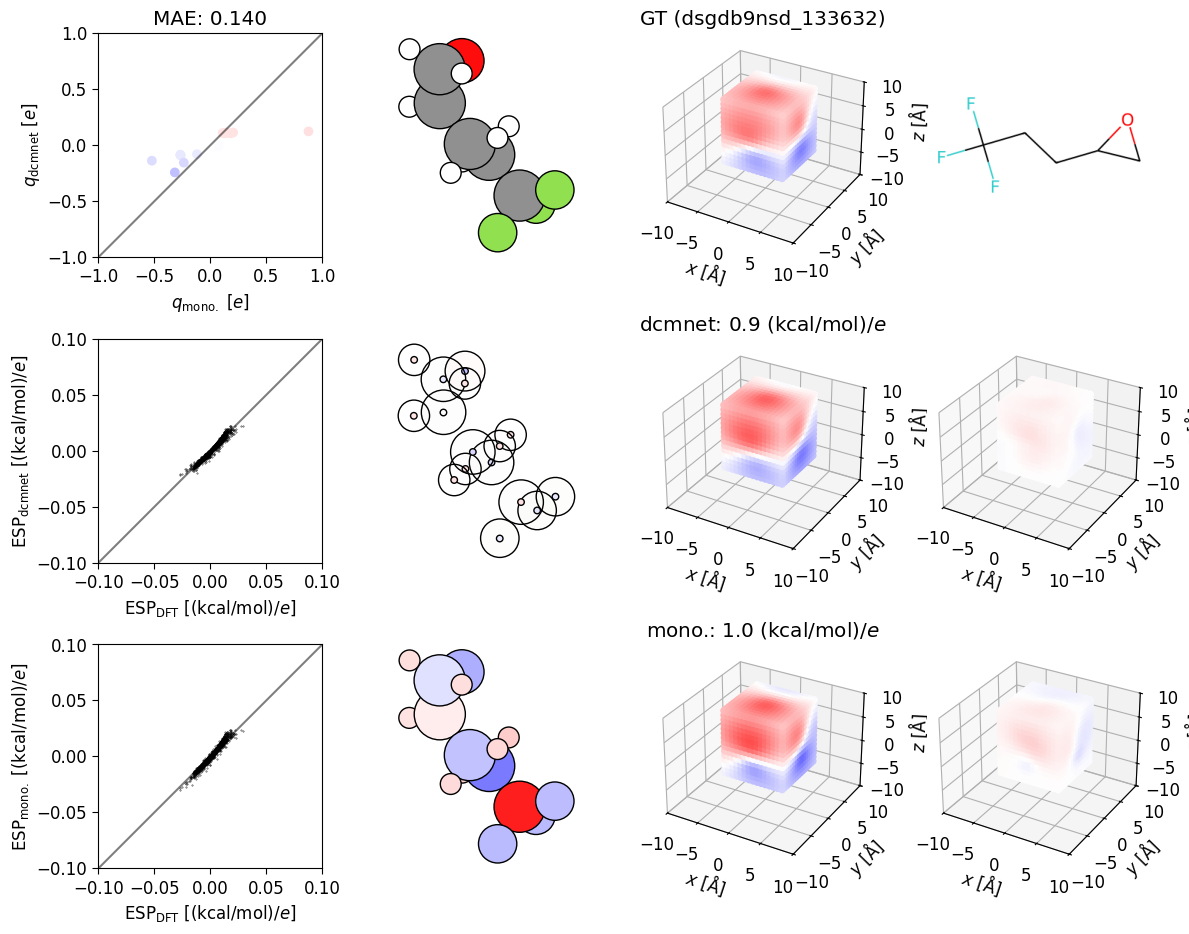

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 4/5 [00:20<00:05,  5.19s/it]

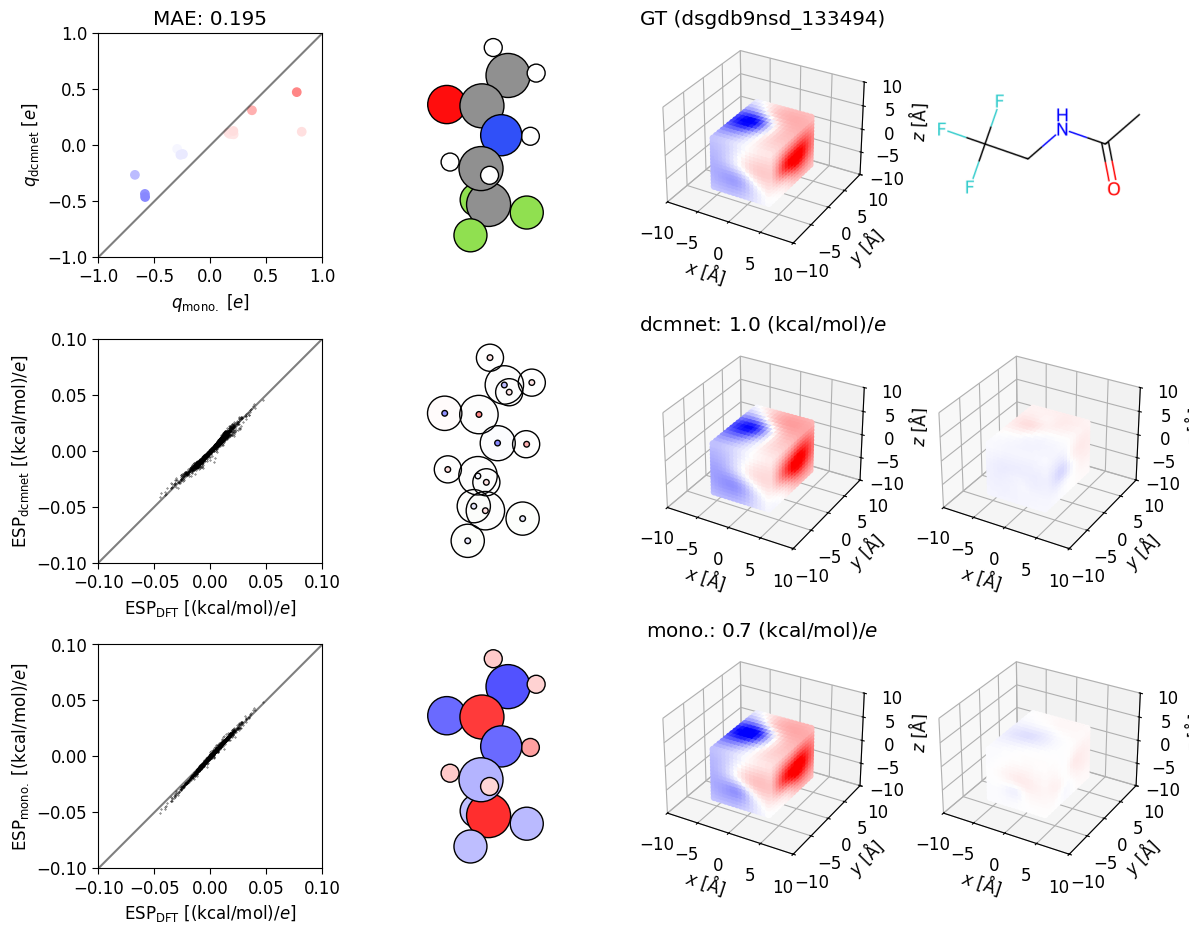

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]


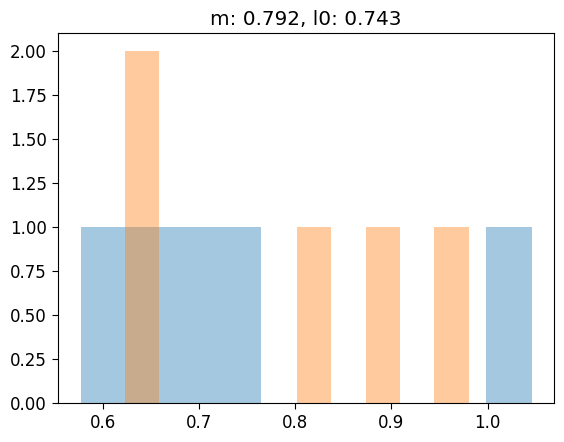

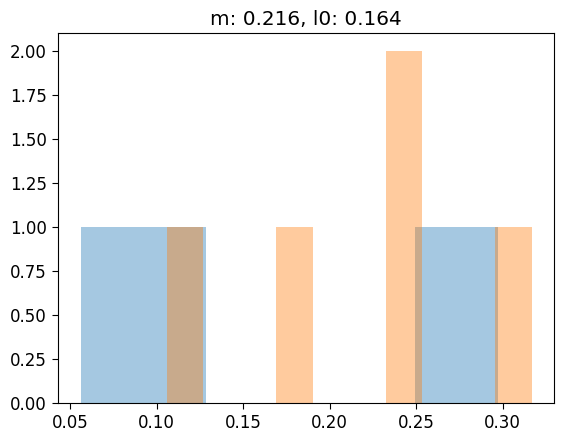

In [557]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(good[:5]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [558]:

bad = list(df_[df_["dif"] > 0].sort_values("dif", ascending=False)["i"])
len(bad)
df_[df_["dif"] > 0].describe()

i          m         l0         dm        dl0        dif  \
count    94.000000  94.000000  94.000000  94.000000  94.000000  94.000000   
mean   3421.585106   1.971500   1.112228   0.676043   0.227934   0.859273   
std    1905.798850   0.694459   0.301831   0.472060   0.167902   0.598590   
min       8.000000   0.833848   0.462168   0.011803   0.001412   0.025753   
25%    1852.250000   1.518103   0.913311   0.258760   0.093406   0.440891   
50%    3385.000000   1.832740   1.069840   0.639901   0.201333   0.780474   
75%    5187.500000   2.389628   1.275377   1.006368   0.353344   1.208644   
max    6440.000000   4.517420   2.014815   1.893220   0.737154   3.341852   

            difd  
count  94.000000  
mean    0.448110  
std     0.475759  
min    -0.382399  
25%     0.092060  
50%     0.371312  
75%     0.826512  
max     1.780156

  0%|                                                                                                        | 0/5 [00:00<?, ?it/s]

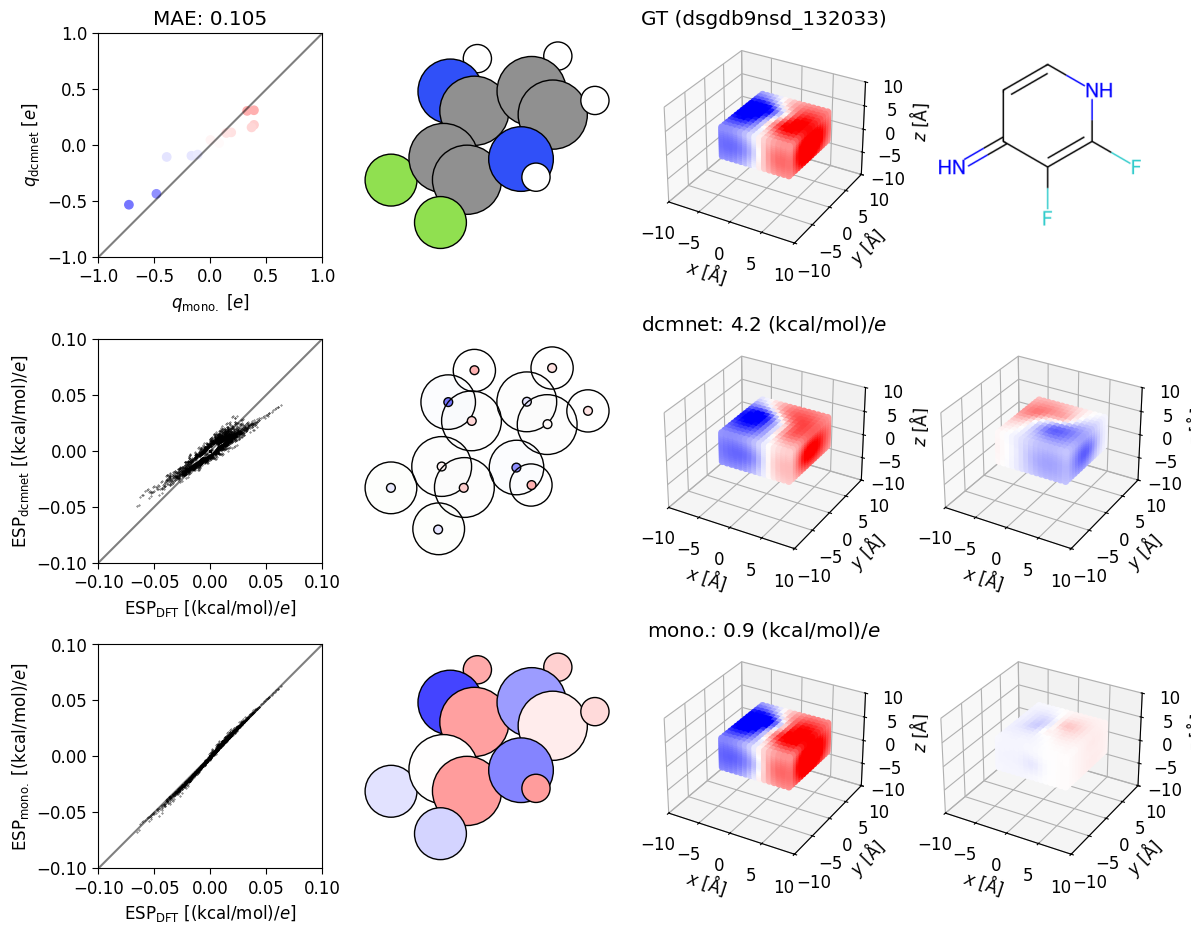

 20%|███████████████████▏                                                                            | 1/5 [00:06<00:24,  6.14s/it]

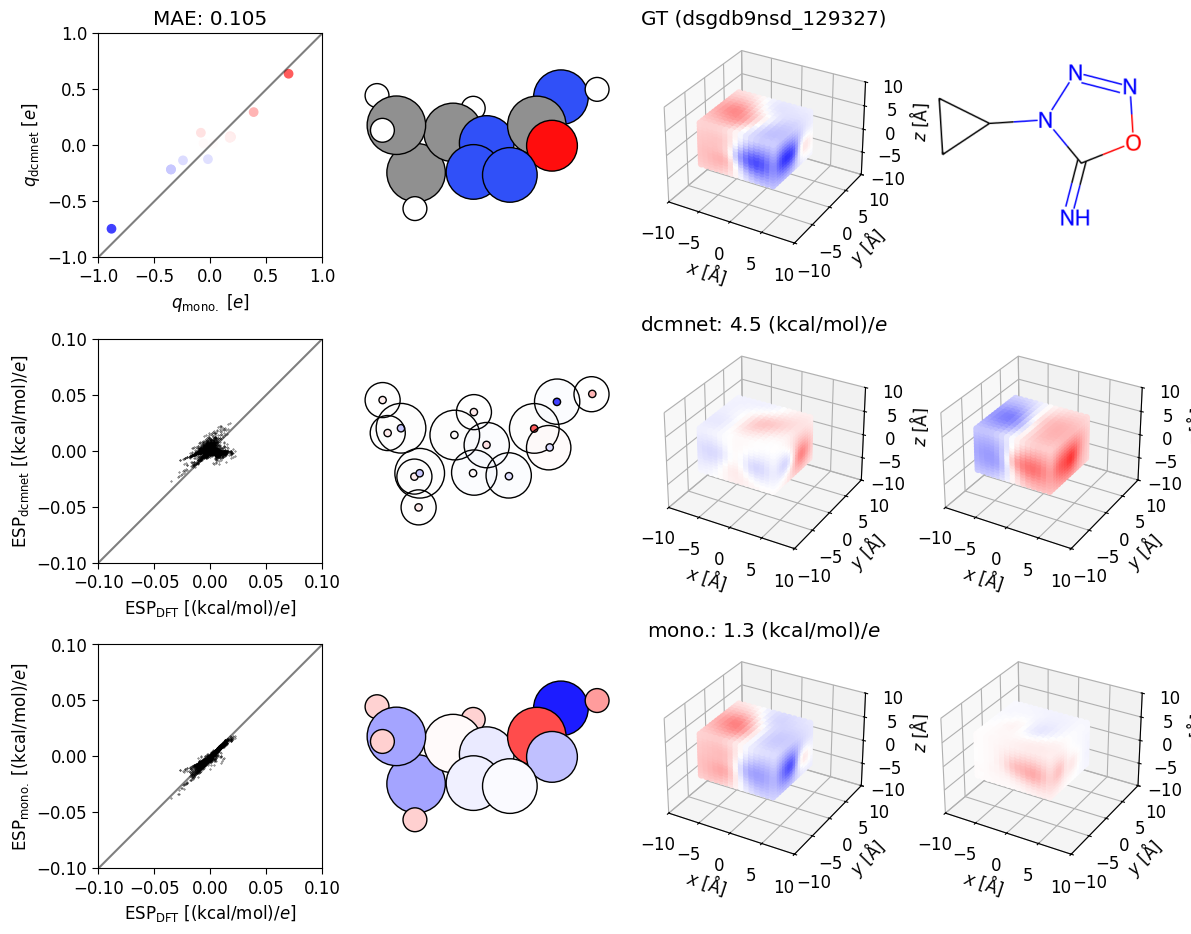

 40%|██████████████████████████████████████▍                                                         | 2/5 [00:11<00:16,  5.57s/it]

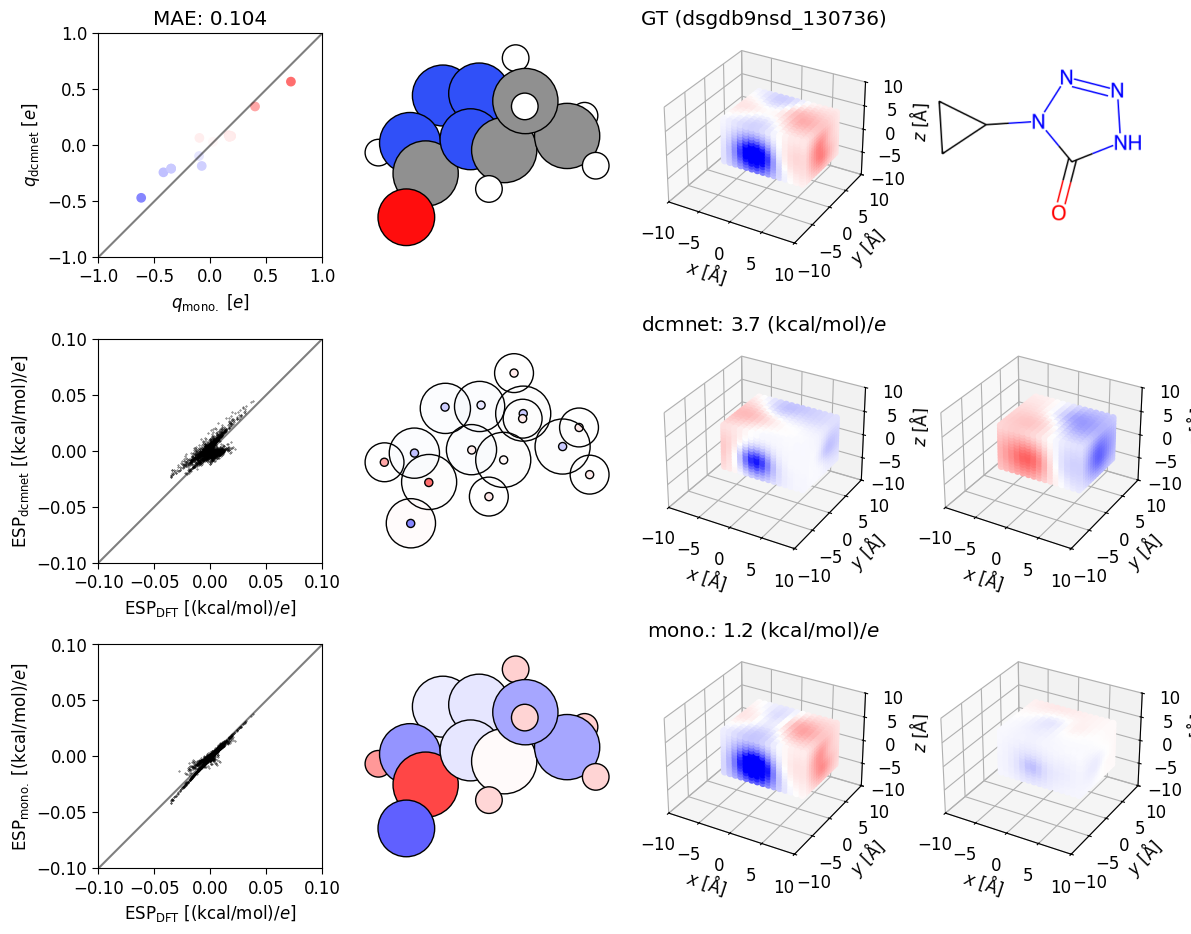

 60%|█████████████████████████████████████████████████████████▌                                      | 3/5 [00:16<00:10,  5.38s/it]

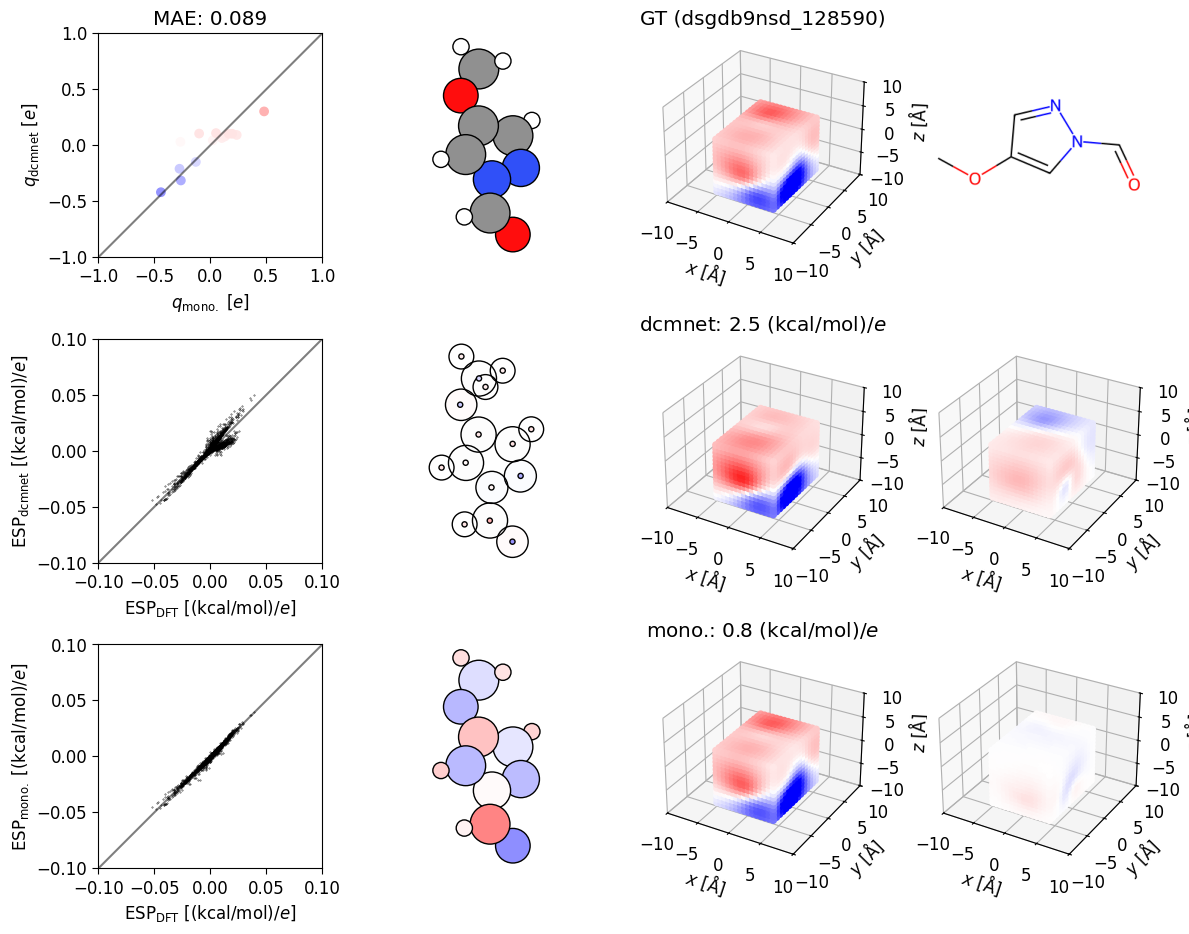

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 4/5 [00:21<00:05,  5.28s/it]

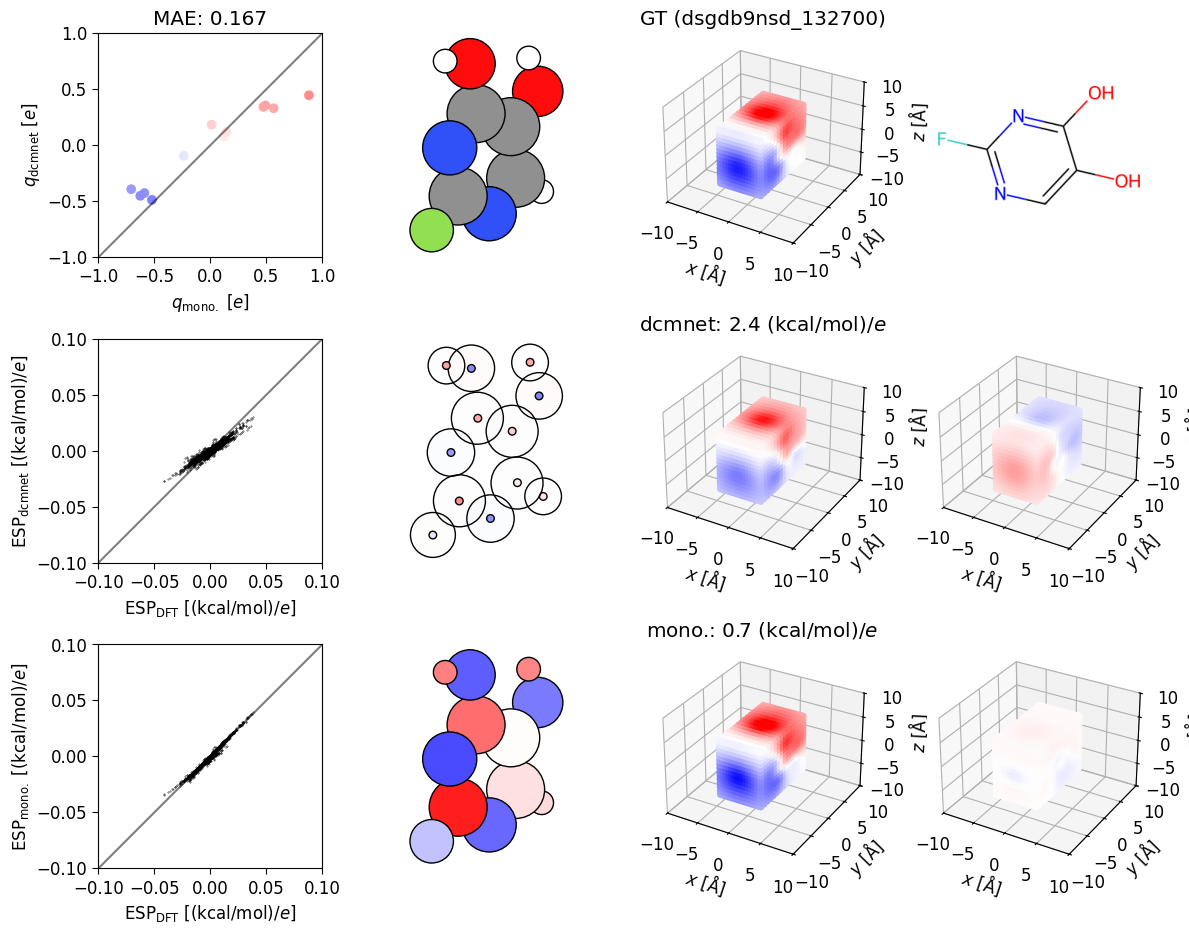

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


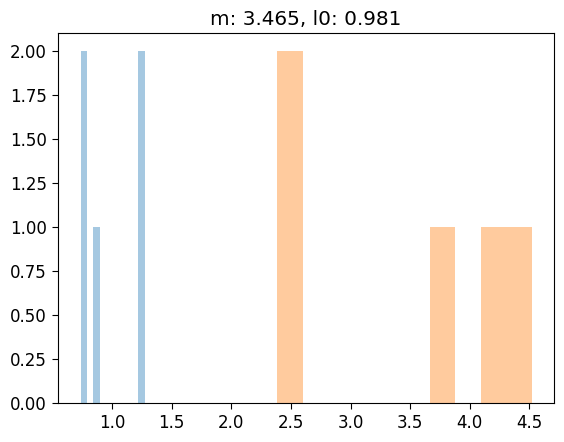

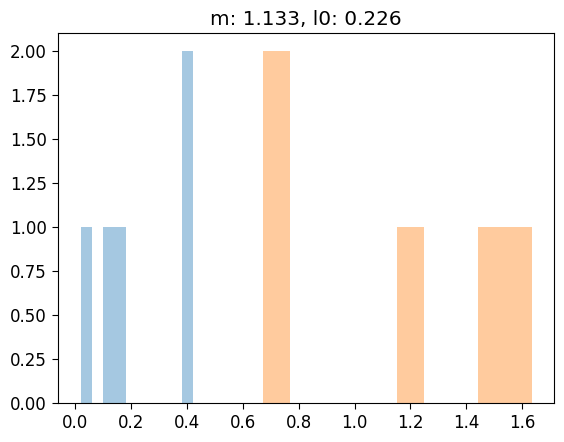

In [559]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad[:5]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [541]:
import ase
old_params = params

In [542]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

# p = ddir / "test2/20240926-195014dcm-2-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"
p = ddir / "test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201913dcm-3-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201827dcm-4-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"

print(p)
model, params = create_model_and_params(p, debug=True)
model

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': False, 'debug': True}


MessagePassingModelDEBUG(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
    include_pseudotensors = False
)

In [439]:
# batch

In [440]:
model.apply(params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,)

basis [[[[ 2.0759298e-06  4.2702464e-05  4.0992099e-04 ...  1.3223335e-02
     2.5905517e-03  2.3683706e-04]
   [-1.5792479e-07 -3.2485577e-06 -3.1184431e-05 ... -1.0059552e-03
    -1.9707426e-04 -1.8017201e-05]
   [-2.0675072e-06 -4.2529209e-05 -4.0825782e-04 ... -1.3169684e-02
    -2.5800411e-03 -2.3587614e-04]
   ...
   [-1.3149524e-08 -2.7048944e-07 -2.5965549e-06 ... -8.3760329e-05
    -1.6409283e-05 -1.5001926e-06]
   [-1.7214988e-07 -3.5411717e-06 -3.3993369e-05 ... -1.0965668e-03
    -2.1482575e-04 -1.9640102e-05]
   [-1.0307689e-06 -2.1203208e-05 -2.0353954e-04 ... -6.5658302e-03
    -1.2862959e-03 -1.1759756e-04]]]


 [[[ 3.6390531e-09  1.3645447e-07  2.3877778e-06 ...  5.6883842e-02
     2.0314198e-02  3.3854528e-03]
   [-1.8225248e-09 -6.8339666e-08 -1.1958563e-06 ... -2.8488789e-02
    -1.0173836e-02 -1.6955157e-03]
   [-3.1450329e-09 -1.1793008e-07 -2.0636248e-06 ... -4.9161568e-02
    -1.7556442e-02 -2.9258602e-03]
   ...
   [-1.4994522e-10 -5.6225331e-09 -9.8387098e-08 

(Array([[-0.11719884, -0.48799357],
        [ 0.04557166,  0.2693724 ],
        [ 0.00734286,  0.09362167],
        [-0.09214447, -0.32343695],
        [ 0.03853337,  0.25738138],
        [-0.07496716, -0.33597243],
        [-0.11278939, -0.3031791 ],
        [-0.00682716,  0.11286114],
        [-0.08350667, -0.2752007 ],
        [ 0.05361644,  0.22390643],
        [ 0.05608395,  0.22037187],
        [ 0.05781018,  0.28628322],
        [ 0.05923039,  0.26795542],
        [ 0.042298  ,  0.06166424],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.03061   ],
        [-0.00076892,  0.030

In [156]:
params["params"].keys()

dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [319]:
EMBED = params["params"]["Embed_0"]["embedding"].squeeze(axis=1).squeeze(axis=1)
EMBED.shape

(18, 16)

Text(0.5, 0, 'Feature')

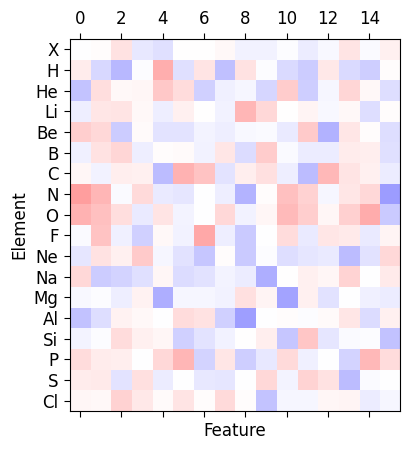

In [320]:
plt.matshow(EMBED, vmin=-2, vmax=2)
ax = plt.gca()
_ = ax.set_yticks(range(EMBED.shape[0]), ase.data.chemical_symbols[:EMBED.shape[0]])
ax.set_ylabel("Element")
ax.set_xlabel("Feature")

(3, 3, 16)


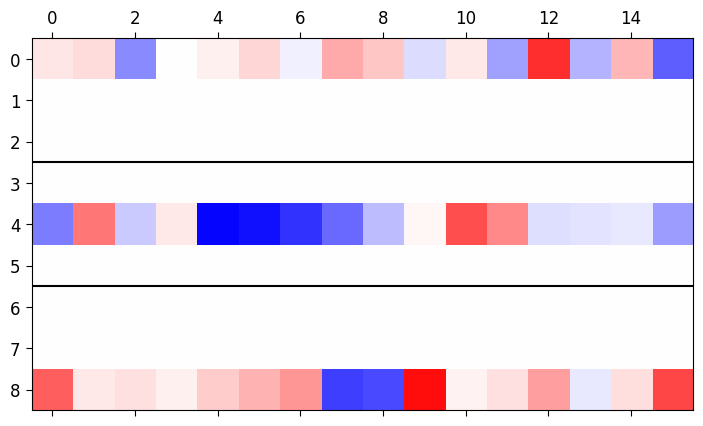

In [317]:
X = params\
    ["params"]["MessagePass_0"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(9,16)
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, color="k")
plt.axhline(5.5, color="k")

(3, 3, 3, 16)


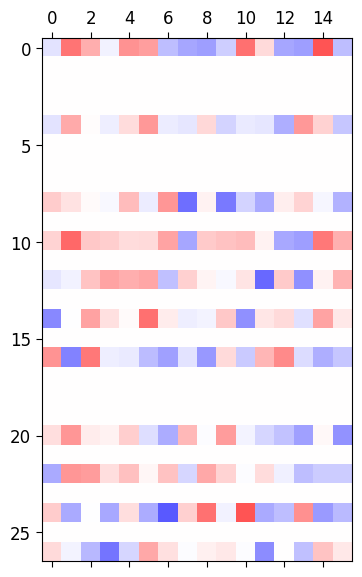

In [318]:
X = params\
    ["params"]["MessagePass_1"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(27,16)
plt.matshow(X, vmin=-2, vmax=2)

In [188]:
params["params"]["element_bias"].shape

(18,)

In [189]:
params["params"]["Dense_1"]

{'0+': {'bias': Array([-0.03781235, -0.01396759,  0.00129313, -0.00032401,  0.01888476,
          0.00201174,  0.10782475,  0.00544562, -0.00438863,  0.10152471,
         -0.04256132,  0.0905747 ,  0.02744431, -0.04963439,  0.06262492,
         -0.04063939], dtype=float32),
  'kernel': Array([[-0.49892464,  0.07763594, -0.19718038, -0.3970621 ,  0.1761006 ,
           0.00412418, -0.41426644,  0.35402223, -0.16925065,  0.29993626,
          -0.24755262, -0.04443164,  0.42402667,  0.17202552,  0.3267142 ,
          -0.12226923],
         [-0.11457382,  0.35371608,  0.20217335,  0.32931092,  0.22117154,
          -0.08841392,  0.23730476, -0.4578464 , -0.21624766, -0.52603674,
           0.18553905,  0.05534945,  0.39950082, -0.01628591,  0.2977889 ,
           0.21983218],
         [-0.04506854, -0.04541539,  0.34398162, -0.5188084 ,  0.40570933,
          -0.2271969 ,  0.11919681, -0.13477631, -0.13008596,  0.10790412,
          -0.06830552,  0.24216926,  0.0312066 ,  0.05992835,  0.02

In [239]:
DENSE0 = params["params"]["Dense_0"]
DENSE0.keys()

dict_keys(['0+', '1-', '2+'])

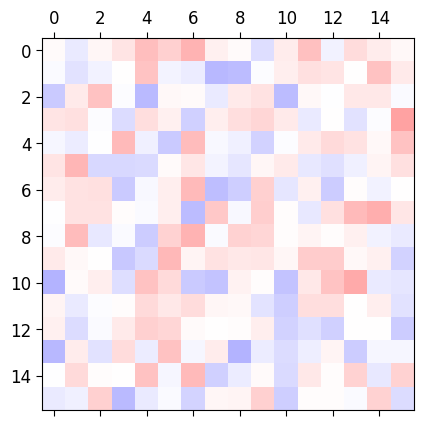

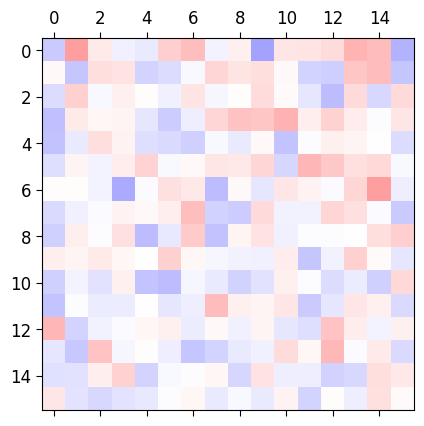

In [242]:
plt.matshow(DENSE0["0+"]["kernel"], vmin=-2, vmax=2)
plt.matshow(DENSE0["1-"]["kernel"], vmin=-2, vmax=2)
# plt.colorbar()

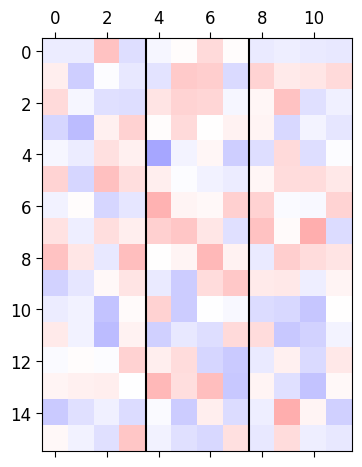

In [307]:
types = ["0+", "1-", "2+"]
X = np.array([params["params"]["TensorDense_0"]["dense"][_]["kernel"].T for _ in types]).reshape(12,16).T
plt.matshow(X, vmin=-2, vmax=2)
plt.axvline(3.5, color="k")
plt.axvline(7.5, color="k")

In [328]:
# params["params"]["TensorDense_0"]

In [321]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze() #.reshape(9,4)
# X.shape, X

In [322]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze().reshape(9,4)
X.shape

(9, 4)

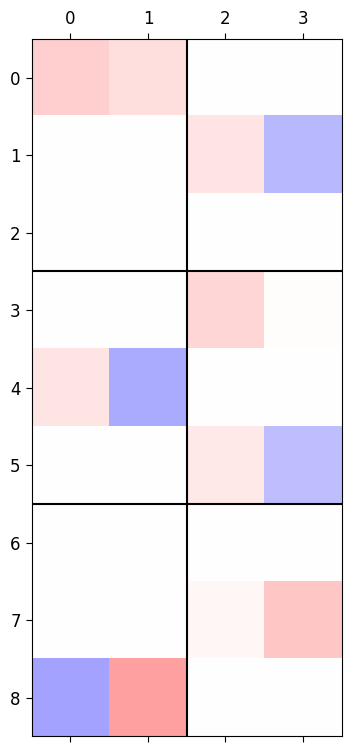

In [323]:
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, c="k")
plt.axhline(5.5, c="k")
plt.axvline(1.5, c="k")

In [324]:
X.shape

(9, 4)

In [326]:
params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze().shape

(3, 3, 2, 2)